In [1]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP')
import yaml
import numpy as np
from torch import Tensor
import torch
import matplotlib.pyplot as plt
from run_experiments.prepare_dataset import *
from utils_general import prepare_common_background_info, pred4all_outputs_inputs, evaluate_on_single_output, plot_traindata_testdata_fittedgp, neg_log_likelihood
from code_blocks.our_models.lvmogp_svi import LVMOGP_SVI
from code_blocks.likelihoods.gaussian_likelihood import GaussianLikelihood

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
config_name = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/configs/synthetic/Scale_RBF/lvmogp_50_outputs_unfix.yaml'
model_path = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/experiments_results/synthetic/Scale_RBF/lvmogp_50_outputs_unfix/2024-02-23_10:35:35/model.pth'
likelihood_path = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/experiments_results/synthetic/Scale_RBF/lvmogp_50_outputs_unfix/2024-02-23_10:35:35/likelihood.pth'

## Load in model

In [4]:
with open(config_name) as file:
    config = yaml.safe_load(file)

my_model = LVMOGP_SVI(
        n_outputs = config['n_outputs'],
        n_input = config['n_input_train'],                    # NOTE PAY ATTENTION, not total n_inputs.
        input_dim = config['input_dim'],
        latent_dim = config['latent_dim'],
        n_inducing_input = config['n_inducing_input'],
        n_inducing_latent = config['n_inducing_latent'],
        learn_inducing_locations_latent = config['learn_inducing_locations_latent'],
        learn_inducing_locations_input = config['learn_inducing_locations_input'],
        latent_kernel_type = config['latent_kernel_type'],
        input_kernel_type = config['input_kernel_type'],
        trainable_latent_dim = config['trainable_latent_dim'] if 'trainable_latent_dim' in config else None,
        latent_first_init = None,                               # if None, random initialization
        latent_second_init = None,                              # if None, random initialization
        NNEncoder = config['NNEncoder'],
        layers = None                                           # if none, adopt default value [4, 8, 4]
    )   

my_likelihood = GaussianLikelihood()

In [5]:
model_state_dict = torch.load(model_path)
my_model.load_state_dict(model_state_dict)

likelihood_state_dict = torch.load(likelihood_path)
my_likelihood.load_state_dict(likelihood_state_dict)

<All keys matched successfully>

## Look at latent variables

## Load in dataset

In [6]:
if config['dataset_type'] == 'synthetic_regression':
        data_inputs, data_Y_squeezed, ls_of_ls_train_input, ls_of_ls_test_input, train_sample_idx_ls, test_sample_idx_ls = prepare_synthetic_regression_data(config)
        means, stds = None, None
        
n_data4visual = 500
inputs_total4visual = Tensor(np.linspace(config['min_input_bound'], config['max_input_bound'], n_data4visual))

## Test via integration (datapoint by datapoint)

### The function

In [ ]:
from linear_operator.operators import CholLinearOperator, KroneckerProductLinearOperator
from linear_operator.operators import (
    LinearOperator,
    TriangularLinearOperator,
)
from linear_operator.utils.cholesky import psd_safe_cholesky
from linear_operator import to_dense
from gpytorch.settings import _linalg_dtype_cholesky

def prepare_common_background_info(my_model, config):
    '''Prepare all values of a dict called common_background_information, which being used in integration_prediction_func'''
    
    def _cholesky_factor(induc_induc_covar: LinearOperator) -> TriangularLinearOperator:
        L = psd_safe_cholesky(to_dense(induc_induc_covar).type(_linalg_dtype_cholesky.value()), max_tries=4)
        return TriangularLinearOperator(L)
    
    K_uu_latent = my_model.covar_module_latent(my_model.variational_strategy.inducing_points_latent.data).to_dense().to(torch.float64)
    # K_uu_latent_inv = torch.linalg.solve(K_uu_latent, torch.eye(K_uu_latent.size(-1)).to(torch.float64))
    K_uu_input = my_model.covar_module_input(my_model.variational_strategy.inducing_points_input.data).to_dense().to(torch.float64)
    # K_uu_input_inv = torch.linalg.solve(K_uu_input, torch.eye(K_uu_input.size(-1)).to(torch.float64))

    K_uu = KroneckerProductLinearOperator(K_uu_latent, K_uu_input).to_dense().data
    # chol_K_uu_inv_t = _cholesky_factor_latent(KroneckerProductLinearOperator(K_uu_latent_inv, K_uu_input_inv)).to_dense().data.t()
    chol_K_uu_inv_t = KroneckerProductLinearOperator(
            torch.linalg.solve( _cholesky_factor(K_uu_latent).to_dense().data, torch.eye(K_uu_latent.size(-1)).to(torch.float64)),
            torch.linalg.solve( _cholesky_factor(K_uu_input).to_dense().data, torch.eye(K_uu_input.size(-1)).to(torch.float64)),
        ).to_dense().data.t()
    # ------------------------------------------------------------------------------------------------------------------------------------------------------------------

    chol_covar_latent_u = my_model.variational_strategy._variational_distribution.chol_variational_covar_latent.data.to(torch.float64)
    covar_latent_u = CholLinearOperator(chol_covar_latent_u).to_dense()
    chol_covar_input_u = my_model.variational_strategy._variational_distribution.chol_variational_covar_input.data.to(torch.float64)
    covar_input_u = CholLinearOperator(chol_covar_input_u).to_dense()

    covar_u = KroneckerProductLinearOperator(covar_latent_u, covar_input_u).to_dense().data

    # ------------------------------------------------------------------------------------------------------------------------------------------------------------------

    common_background_information = {
                        'K_uu': K_uu.data,
                        'chol_K_uu_inv_t': chol_K_uu_inv_t.data, 
                        'm_u': my_model.variational_strategy._variational_distribution.variational_mean.data,
                        'Sigma_u': covar_u.data,
                        'A': chol_K_uu_inv_t @ (covar_u - torch.eye(covar_u.shape[0])) @ chol_K_uu_inv_t.t(),
                        'var_H': my_model.covar_module_latent.outputscale.data,
                        'var_X': my_model.covar_module_input.outputscale.data,
                        'W': my_model.covar_module_latent.base_kernel.lengthscale.data.reshape(-1)**2
                        }
    '''
    chol_K_uu_inv_t: inverse of K_uu matrix, of shape (M_H * M_X, M_H * M_X)
    m_u: mean of the variational distribution
    Sigma_u: covariance matrix of the variational distribution
    A: chol_K_uu_inv_t (Sigma_u - K_uu) chol_K_uu_inv_t.T
    var_H: 
    var_X: 
    W: vector; containing all lengthscales in the RAD kernel
    c: constant
    '''
    # ------------------------------------------------------------------------------------------------------------------------------------------------------------------
    c = (2 * torch.pi)**(config['latent_dim'] / 2) * common_background_information['var_H'] * common_background_information['W'].sqrt().prod()
    common_background_information['constant_c'] = c

    return common_background_information

common_background_information = prepare_common_background_info(my_model, config)

def integration_prediction_func(test_input, output_index, my_model, common_background_information=common_background_information):

    input_K_f_u = my_model.covar_module_input(test_input, my_model.variational_strategy.inducing_points_input.data).to_dense().data
    input_K_u_f_K_f_u = input_K_f_u.t() @ input_K_f_u

    data_specific_background_information = {
            'm_plus': my_model.X.q_mu.data[output_index],
            'Sigma_plus': 1.0 * my_model.X.q_log_sigma.exp().square().data[output_index],
            'input_K_f_u': input_K_f_u, 
            'input_K_u_f_K_f_u': input_K_u_f_K_f_u,
            'expectation_K_uu': None
    }
    
    # helper functions -----------------------------------------------------------------------------------------------------------------------
    def multivariate_gaussian_pdf(x, mu, cov):
        '''cov is a vector, representing all elements in the diagonal matrix'''
        k = mu.size(0)
        cov_det = cov.prod()
        cov_inv = torch.diag(1.0 / cov)
        norm_factor = torch.sqrt((2 * torch.pi) ** k * cov_det)

        x_mu = x - mu
        result = torch.exp(-0.5 * x_mu @ cov_inv @ x_mu.t()) / norm_factor
        return result.item()

    def G(h:Tensor, common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):

        mu = data_specific_background_information['m_plus']
        cov_diag = data_specific_background_information['Sigma_plus'] + common_background_information['W']
        result = multivariate_gaussian_pdf(h, mu, cov_diag)
        return common_background_information['constant_c'] * result

    def R(h_1:Tensor, h_2:Tensor, common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
        mu_1 = h_2
        cov_diag_1 = 2 * common_background_information['W']
        mu_2 = (h_1 + h_2) / 2
        cov_diag_2 = 0.5 * common_background_information['W'] + data_specific_background_information['Sigma_plus']
        result1 = multivariate_gaussian_pdf(h_1, mu_1, cov_diag_1)
        result2 = multivariate_gaussian_pdf(data_specific_background_information['m_plus'], mu_2, cov_diag_2)
        return (common_background_information['constant_c'] ** 2 ) * result1 * result2
    
    def expectation_lambda(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
        result_ = KroneckerProductLinearOperator(data_specific_background_information['expectation_latent_K_f_u'].reshape(1, -1), data_specific_background_information['input_K_f_u'].reshape(1, -1)).to_dense().data 
        result_ = result_ @ common_background_information['chol_K_uu_inv_t'].to(result_.dtype) @ common_background_information['m_u'].to(result_.dtype)
        return result_
        
    def expectation_lambda_square(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
        result_ = common_background_information['m_u']
        _result = result_ @ common_background_information['chol_K_uu_inv_t'].t().to(result_.dtype)
        interm_term = KroneckerProductLinearOperator(data_specific_background_information['expectation_latent_K_u_f_K_f_u'], data_specific_background_information['input_K_u_f_K_f_u']).to_dense().data
        result_ = _result @ interm_term.to(result_.dtype) @ _result.t()
        # result_ = result_ @ common_background_information['chol_K_uu_inv_t'].to(result_.dtype) @ common_background_information['m_u']

        if data_specific_background_information['expectation_K_uu'] == None:
            data_specific_background_information['expectation_K_uu'] = interm_term
        return result_
        
    def expectation_gamma(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
        result_ = common_background_information['var_H'] * common_background_information['var_X']

        if data_specific_background_information['expectation_K_uu'] == None:
            data_specific_background_information['expectation_K_uu'] = KroneckerProductLinearOperator(data_specific_background_information['expectation_latent_K_u_f_K_f_u'], \
                                                                                                    data_specific_background_information['input_K_u_f_K_f_u']).to_dense().data
        result = result_ + (common_background_information['A'] * data_specific_background_information['expectation_K_uu']).sum()
        return result
    
    def integration_predictive_mean(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
        return expectation_lambda(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information)


    def integration_predictive_var(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information):
        return expectation_lambda_square(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information) \
            + expectation_gamma(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information) \
            - expectation_lambda(common_background_information=common_background_information, data_specific_background_information=data_specific_background_information)**2
    
    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    expectation_latent_K_f_u = Tensor([G(my_model.variational_strategy.inducing_points_latent.data[i]).item() for i in range(config['n_inducing_latent'])])
    expectation_latent_K_u_f_K_f_u = Tensor([R(my_model.variational_strategy.inducing_points_latent.data[i], my_model.variational_strategy.inducing_points_latent.data[j]).item() \
                                            for j in range(config['n_inducing_latent']) for i in range(config['n_inducing_latent'])]).reshape(config['n_inducing_latent'], config['n_inducing_latent'])

    data_specific_background_information['expectation_latent_K_f_u'] = expectation_latent_K_f_u
    data_specific_background_information['expectation_latent_K_u_f_K_f_u'] = expectation_latent_K_u_f_K_f_u
    
    return integration_predictive_mean(data_specific_background_information=data_specific_background_information), \
           integration_predictive_var(data_specific_background_information=data_specific_background_information)

### predict

In [ ]:
from tqdm import trange

In [ ]:
my_model.eval()
my_likelihood.eval()

all_index_latent = np.array([[i]*config['n_input'] for i in range(config['n_outputs'])]).reshape(-1).tolist() 
all_index_input = [i for i in range(config['n_input'])] * config['n_outputs'] 
len_outputs = len(all_index_latent)
assert len_outputs == len(all_index_input)

all_pred_mean_slow = torch.zeros(len_outputs)
all_pred_var_slow = torch.zeros(len_outputs)

# iteratively inference
for idx in trange(len_outputs, leave=True):
    curr_latent_index = all_index_latent[idx]
    curr_input = data_inputs[all_index_input[idx]].reshape(-1)
    curr_pred_mean, curr_pred_var = integration_prediction_func(test_input=curr_input,
                                                                output_index=curr_latent_index,
                                                                my_model=my_model,
                                                                common_background_information=common_background_information)
    all_pred_mean_slow[idx] = curr_pred_mean
    all_pred_var_slow[idx] = curr_pred_var + my_likelihood.noise.data
    

In [ ]:
train_data_predict = all_pred_mean_slow[train_sample_idx_ls]
train_rmse = (train_data_predict - data_Y_squeezed[train_sample_idx_ls]).square().mean().sqrt()
print('Global Train RMSE via integration', train_rmse)

w_test_data_predict = all_pred_mean_slow[test_sample_idx_ls]
test_rmse = (w_test_data_predict - data_Y_squeezed[test_sample_idx_ls]).square().mean().sqrt()
print('Global Test RMSE via integration', test_rmse)


In [ ]:
train_nll = neg_log_likelihood(Target=data_Y_squeezed[train_sample_idx_ls], GaussianMean=all_pred_mean_slow[train_sample_idx_ls], GaussianVar=all_pred_var_slow[train_sample_idx_ls])
test_nll = neg_log_likelihood(Target=data_Y_squeezed[test_sample_idx_ls], GaussianMean=all_pred_mean_slow[test_sample_idx_ls], GaussianVar=all_pred_var_slow[test_sample_idx_ls])

print('Global Train negative log likelihood via integration:', train_nll)
print('Global Test negative log likelihood via integration:', test_nll)

## Test via integration (output by output)

In [7]:
common_background_information = prepare_common_background_info(my_model, config)

In [8]:
all_pred_mean, all_pred_var = pred4all_outputs_inputs(my_model=my_model,
                                                        my_likelihood=my_likelihood,
                                                        data_inputs=data_inputs,
                                                        config=config,
                                                        common_background_information=common_background_information,
                                                        approach='integration')


100%|██████████| 50/50 [00:14<00:00,  3.40it/s]


In [9]:
all_pred_mean4visual, all_pred_var4visual = pred4all_outputs_inputs(my_model=my_model,
                                                        my_likelihood=my_likelihood,
                                                        data_inputs=inputs_total4visual,
                                                        config=config,
                                                        common_background_information=common_background_information,
                                                        approach='integration',
                                                        not4visual=False,
                                                        n_data4visual=n_data4visual)


100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


### Metrices

In [10]:
train_data_predict = all_pred_mean[train_sample_idx_ls]
train_rmse = (train_data_predict - data_Y_squeezed[train_sample_idx_ls]).square().mean().sqrt()
print('Global Train RMSE via integration', train_rmse)

w_test_data_predict = all_pred_mean[test_sample_idx_ls]
test_rmse = (w_test_data_predict - data_Y_squeezed[test_sample_idx_ls]).square().mean().sqrt()
print('Global Test RMSE via integration', test_rmse)


Global Train RMSE via integration tensor(0.2504)
Global Test RMSE via integration tensor(0.3935)


In [11]:
train_nll = neg_log_likelihood(Target=data_Y_squeezed[train_sample_idx_ls], GaussianMean=all_pred_mean[train_sample_idx_ls], GaussianVar=all_pred_var[train_sample_idx_ls])
test_nll = neg_log_likelihood(Target=data_Y_squeezed[test_sample_idx_ls], GaussianMean=all_pred_mean[test_sample_idx_ls], GaussianVar=all_pred_var[test_sample_idx_ls])

print('Global Train negative log likelihood via integration:', train_nll)
print('Global Test negative log likelihood via integration:', test_nll)

Global Train negative log likelihood via integration: tensor(0.1834)
Global Test negative log likelihood via integration: tensor(0.4697)


### Loop over all function index

In [12]:
train_rmse_list = [] # list of tensors
test_rmse_list = []
train_nll_list = []
test_nll_list = []
for output_index in range(config['n_outputs']):
    _, _, _, _, _, _, performance_dirct = evaluate_on_single_output(
                                                        function_index = output_index,
                                                        data_inputs = data_inputs,
                                                        data_Y_squeezed = data_Y_squeezed,
                                                        ls_of_ls_train_input = ls_of_ls_train_input,
                                                        ls_of_ls_test_input = ls_of_ls_test_input,
                                                        train_sample_idx_ls = train_sample_idx_ls,
                                                        test_sample_idx_ls = test_sample_idx_ls,
                                                        all_pred_mean = all_pred_mean,
                                                        all_pred_var = all_pred_var,
                                                        n_data4visual = n_data4visual,
                                                        all_pred_mean4visual = all_pred_mean4visual,
                                                        all_pred_var4visual = all_pred_var4visual                                                        
                                                        )
    train_rmse_list.append(performance_dirct['train_rmse'])
    test_rmse_list.append(performance_dirct['test_rmse'])
    train_nll_list.append(performance_dirct['train_nll'])
    test_nll_list.append(performance_dirct['test_nll'])

In [13]:
def find_median_index(lst):
    sorted_lst = sorted(lst)
    n = len(lst)
    
    if n % 2 != 0:
        median = sorted_lst[n // 2]
        return lst.index(median)
    else:
        mid1 = sorted_lst[n // 2 - 1]
        mid2 = sorted_lst[n // 2]
        
        return lst.index(mid1)  # lst.index(mid2)

In [14]:
print('The output index with WORSE test rmse performance: ', test_rmse_list.index(max(test_rmse_list)))
print('The output index with WORSE test nll performance: ', test_nll_list.index(max(test_nll_list)))
print('------' * 10)
print('The output index with MIDDLE test rmse performance:', find_median_index(test_rmse_list))
print('The output index with MIDDLE test nll performance:', find_median_index(test_nll_list))
print('------' * 10)
print('The output index with BEST test rmse performance: ', test_rmse_list.index(min(test_rmse_list)))
print('The output index with BEST test nll performance: ', test_nll_list.index(min(test_nll_list)))

The output index with WORSE test rmse performance:  1
The output index with WORSE test nll performance:  1
------------------------------------------------------------
The output index with MIDDLE test rmse performance: 2
The output index with MIDDLE test nll performance: 2
------------------------------------------------------------
The output index with BEST test rmse performance:  32
The output index with BEST test nll performance:  32


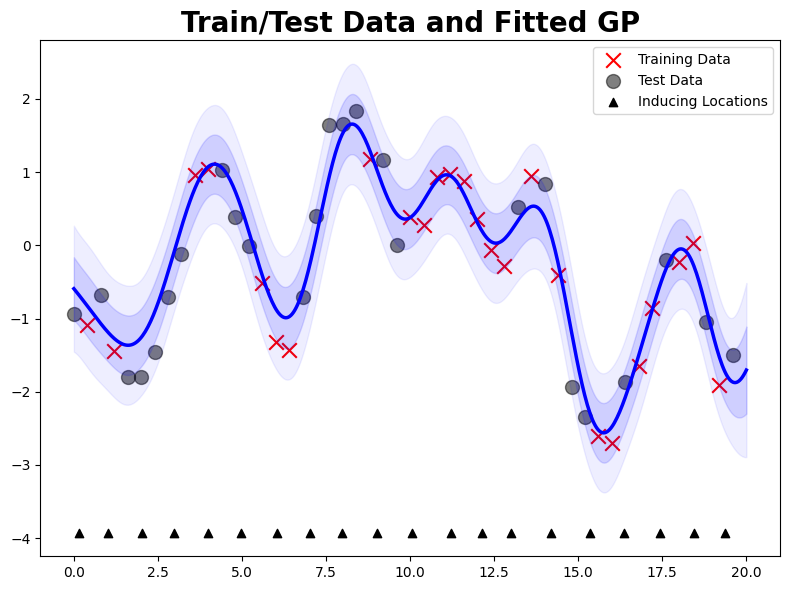

In [15]:
function_index = 0
w_train_input, w_train_target, w_test_input, w_test_target, w_gp_pred_mean, w_gp_pred_std, performance_dirct = evaluate_on_single_output(
                                                        function_index = function_index,
                                                        data_inputs = data_inputs,
                                                        data_Y_squeezed = data_Y_squeezed, 
                                                        ls_of_ls_train_input = ls_of_ls_train_input,
                                                        ls_of_ls_test_input = ls_of_ls_test_input,
                                                        train_sample_idx_ls = train_sample_idx_ls,
                                                        test_sample_idx_ls = test_sample_idx_ls,
                                                        all_pred_mean = all_pred_mean,
                                                        all_pred_var = all_pred_var,
                                                        n_data4visual = n_data4visual,
                                                        all_pred_mean4visual = all_pred_mean4visual,
                                                        all_pred_var4visual = all_pred_var4visual                                                        
                                                        )

plot_traindata_testdata_fittedgp(train_X=w_train_input, train_Y=w_train_target, test_X=w_test_input, test_Y=w_test_target, gp_X=inputs_total4visual, gp_pred_mean=w_gp_pred_mean, gp_pred_std=w_gp_pred_std, inducing_points_X=my_model.variational_strategy.inducing_points_input.data, n_inducing_C=config['n_inducing_input']) # NOTE: input is C not X

## Test via mean

In [16]:
all_pred_mean_, all_pred_var_ = pred4all_outputs_inputs(my_model=my_model,
                                                        my_likelihood=my_likelihood,
                                                        data_inputs=data_inputs,
                                                        config=config,
                                                        approach='mean')

In [17]:
all_pred_mean4visual_, all_pred_var4visual_ = pred4all_outputs_inputs(my_model=my_model,
                                                        my_likelihood=my_likelihood,
                                                        data_inputs=inputs_total4visual,
                                                        config=config,
                                                        approach='mean',
                                                        not4visual=False,
                                                        n_data4visual=n_data4visual)

In [18]:
train_data_predict_ = all_pred_mean_[train_sample_idx_ls]
train_rmse_ = (train_data_predict_ - data_Y_squeezed[train_sample_idx_ls]).square().mean().sqrt()
print('Global Train RMSE via mean', train_rmse_)

w_test_data_predict_ = all_pred_mean_[test_sample_idx_ls]
test_rmse_ = (w_test_data_predict_ - data_Y_squeezed[test_sample_idx_ls]).square().mean().sqrt()
print('Global Test RMSE via mean', test_rmse_)

Global Train RMSE via mean tensor(0.2485)
Global Test RMSE via mean tensor(0.3928)


In [19]:
train_nll_ = neg_log_likelihood(Target=data_Y_squeezed[train_sample_idx_ls], GaussianMean=all_pred_mean_[train_sample_idx_ls], GaussianVar=all_pred_var_[train_sample_idx_ls])
test_nll_ = neg_log_likelihood(Target=data_Y_squeezed[test_sample_idx_ls], GaussianMean=all_pred_mean_[test_sample_idx_ls], GaussianVar=all_pred_var_[test_sample_idx_ls])

print('Global Train negative log likelihood via mean:', train_nll_)
print('Global Test negative log likelihood via mean:', test_nll_)

Global Train negative log likelihood via mean: tensor(0.1645)
Global Test negative log likelihood via mean: tensor(0.4676)


### Loop over all function index

In [20]:
train_rmse_list_ = [] # list of tensors
test_rmse_list_ = []
train_nll_list_ = []
test_nll_list_ = []
for output_index in range(config['n_outputs']):
    _, _, _, _, _, _, performance_dirct = evaluate_on_single_output(
                                                        function_index = output_index,
                                                        data_inputs = data_inputs,
                                                        data_Y_squeezed = data_Y_squeezed,
                                                        ls_of_ls_train_input = ls_of_ls_train_input,
                                                        ls_of_ls_test_input = ls_of_ls_test_input,
                                                        train_sample_idx_ls = train_sample_idx_ls,
                                                        test_sample_idx_ls = test_sample_idx_ls,
                                                        all_pred_mean = all_pred_mean_,
                                                        all_pred_var = all_pred_var_,
                                                        n_data4visual = n_data4visual,
                                                        all_pred_mean4visual = all_pred_mean4visual_,
                                                        all_pred_var4visual = all_pred_var4visual_                                                        
                                                        )
    train_rmse_list_.append(performance_dirct['train_rmse'])
    test_rmse_list_.append(performance_dirct['test_rmse'])
    train_nll_list_.append(performance_dirct['train_nll'])
    test_nll_list_.append(performance_dirct['test_nll'])

In [21]:
def find_median_index(lst):
    sorted_lst = sorted(lst)
    n = len(lst)
    
    if n % 2 != 0:
        median = sorted_lst[n // 2]
        return lst.index(median)
    else:
        mid1 = sorted_lst[n // 2 - 1]
        mid2 = sorted_lst[n // 2]
        
        return lst.index(mid1)  # lst.index(mid2)

In [22]:
print('The output index with WORSE test rmse performance: ', test_rmse_list_.index(max(test_rmse_list_)))
print('The output index with WORSE test nll performance: ', test_nll_list_.index(max(test_nll_list_)))
print('------' * 10)
print('The output index with MIDDLE test rmse performance:', find_median_index(test_rmse_list_))
print('The output index with MIDDLE test nll performance:', find_median_index(test_nll_list_))
print('------' * 10)
print('The output index with BEST test rmse performance: ', test_rmse_list_.index(min(test_rmse_list_)))
print('The output index with BEST test nll performance: ', test_nll_list_.index(min(test_nll_list_)))

The output index with WORSE test rmse performance:  1
The output index with WORSE test nll performance:  1
------------------------------------------------------------
The output index with MIDDLE test rmse performance: 49
The output index with MIDDLE test nll performance: 2
------------------------------------------------------------
The output index with BEST test rmse performance:  32
The output index with BEST test nll performance:  32


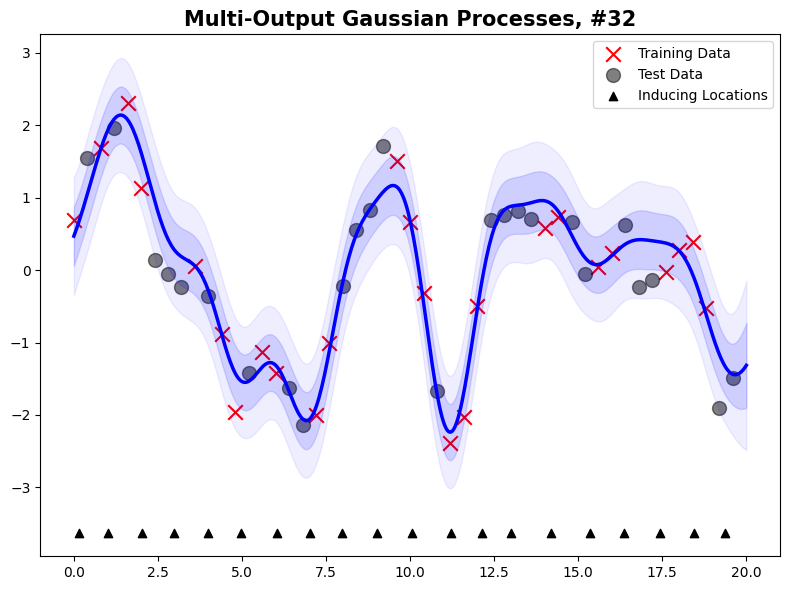

In [23]:
function_index = 49
w_train_input, w_train_target, w_test_input, w_test_target, w_gp_pred_mean, w_gp_pred_std, performance_dirct = evaluate_on_single_output(
                                                        function_index = function_index,
                                                        data_inputs = data_inputs,
                                                        data_Y_squeezed = data_Y_squeezed, 
                                                        ls_of_ls_train_input = ls_of_ls_train_input,
                                                        ls_of_ls_test_input = ls_of_ls_test_input,
                                                        train_sample_idx_ls = train_sample_idx_ls,
                                                        test_sample_idx_ls = test_sample_idx_ls,
                                                        all_pred_mean = all_pred_mean_,
                                                        all_pred_var = all_pred_var_,
                                                        n_data4visual = n_data4visual,
                                                        all_pred_mean4visual = all_pred_mean4visual_,
                                                        all_pred_var4visual = all_pred_var4visual_                                                        
)

plot_traindata_testdata_fittedgp(train_X=w_train_input, 
                                 train_Y=w_train_target, 
                                 test_X=w_test_input, 
                                 test_Y=w_test_target, 
                                 gp_X=inputs_total4visual, 
                                 gp_pred_mean=w_gp_pred_mean, 
                                 gp_pred_std=w_gp_pred_std, 
                                 inducing_points_X=my_model.variational_strategy.inducing_points_input.data, 
                                 n_inducing_C=config['n_inducing_input'], 
                                 title='Multi-Output Gaussian Processes, #32',
                                 title_fontsize=15) # NOTE: input is C not X